In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import seaborn as sns
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FixedLocator, MultipleLocator
import locale
plt.style.use('Solarize_Light2')
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8');

# Dataset
Los datos se toman de la página de datos abiertos de Colombia. datos.gov.co. El instituto encargado de recopilar la información es el instituto Nacional de Salud INS

In [2]:
url = 'https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD'
pdet = pd.read_csv('data/MunicipiosPDET.csv')
censo = pd.read_csv('data/censo_municipal2018.csv')
datos = pd.read_csv(url)

In [3]:
datos.tail(3)

,ID de caso,Fecha de notificación,Código DIVIPOLA,Ciudad de ubicación,Departamento o Distrito,atención,Edad,Sexo,Tipo,Estado,...,FIS,Fecha de muerte,Fecha diagnostico,Fecha recuperado,fecha reporte web,Tipo recuperación,Codigo departamento,Codigo pais,Pertenencia etnica,Nombre grupo etnico
165166,165207,2020-07-15T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,90,M,En estudio,Asintomático,...,Asintomático,NaN,2020-07-15T00:00:00.000,NaN,2020-07-15T00:00:00.000,NaN,11,NaN,NaN,NaN
165167,165208,2020-07-15T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,91,F,En estudio,Asintomático,...,Asintomático,NaN,2020-07-15T00:00:00.000,NaN,2020-07-15T00:00:00.000,NaN,11,NaN,NaN,NaN
165168,165209,2020-07-15T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Casa,18,F,En estudio,Asintomático,...,Asintomático,NaN,2020-07-15T00:00:00.000,NaN,2020-07-15T00:00:00.000,NaN,11,NaN,NaN,NaN


In [4]:
datos['Fecha de muerte'] = pd.to_datetime(datos['Fecha de muerte'])
datos['fecha reporte web'] = pd.to_datetime(datos['fecha reporte web'])

In [5]:
pdet_1 = datos[datos['Código DIVIPOLA'].isin(pdet['CodigoMunicipio'])]
pdet_1 = pdet_1.merge(pdet, how='left', left_on = 'Código DIVIPOLA', right_on='CodigoMunicipio')
pdet_casos = pdet_1.groupby(['fecha reporte web','NombreSubregion'])['ID de caso'].count().unstack().fillna(0)
pdet_casos_acumulados = pdet_casos.cumsum()

pdet_muertes = pdet_1.groupby(['Fecha de muerte','NombreSubregion'])['ID de caso'].count().unstack().fillna(0)
pdet_muertes_acumuladas = pdet_muertes.cumsum()

pdet_casos.tail()

NombreSubregion,ALTO PATÍA Y NORTE DEL CAUCA,ARAUCA,BAJO CAUCA Y NORDESTE ANTIOQUEÑO,CATATUMBO,CHOCÓ,CUENCA DEL CAGUÁN Y PIEDEMONTE CAQUETEÑO,MACARENA GUAVIARE,MONTES DE MARÍA,PACÍFICO MEDIO,PACÍFICO Y FRONTERA NARIÑENSE,PUTUMAYO,SIERRA NEVADA-PERIJÁ-ZONA BANANERA,SUR DE BOLÍVAR,SUR DE CÓRDOBA,SUR DEL TOLIMA,URABÁ ANTIOQUEÑO
fecha reporte web,,,,,,,,,,,,,,,,
2020-07-11,9.0,0.0,4.0,2.0,6.0,11.0,0.0,4.0,9.0,7.0,38.0,115.0,0.0,2.0,1.0,39.0
2020-07-12,20.0,0.0,11.0,2.0,16.0,15.0,0.0,6.0,4.0,7.0,7.0,61.0,1.0,2.0,1.0,60.0
2020-07-13,8.0,1.0,7.0,0.0,2.0,6.0,0.0,1.0,10.0,4.0,1.0,94.0,1.0,7.0,0.0,19.0
2020-07-14,13.0,0.0,11.0,1.0,5.0,6.0,0.0,4.0,54.0,7.0,17.0,106.0,9.0,3.0,0.0,33.0
2020-07-15,24.0,5.0,40.0,7.0,2.0,4.0,6.0,8.0,17.0,26.0,10.0,86.0,1.0,5.0,0.0,73.0


In [6]:
def rollingCases(df, cases, cantidad):
    df_append = pd.DataFrame()
    df = df.rolling(7, min_periods=1, win_type='gaussian').mean(std=2)
    df.reset_index(drop=True, inplace=True)
    df =  df.reindex( columns=df.tail(7).mean().sort_values(ascending=False).index)
    #df = df.sort_values(axis=1, by=df.index[-7:-1].mean(), ascending=False).reset_index(drop=True)
    for ciudad in range(cantidad):
        df_temp = pd.DataFrame()
        # Se toma el indice desde que los casos superan X cantidad
        first_value = df[ df.iloc[:,ciudad] >= cases ].iloc[:,ciudad].head(1)
        if not first_value.empty:
            idx = first_value.index[0]
            df_temp['datos'] = df.iloc[idx:,ciudad]
            df_temp['ciudad'] = df.columns[ciudad]
            df_temp.reset_index(inplace=True)
            df_append = pd.concat([df_append, df_temp])
    return df_append

In [7]:
sns.set()
def graficar(df,titulo,xlabel,ylabel,texto):
    text = []
    ciudades = df['ciudad'].unique()
    #plt.style.use('fivethirtyeight')
    #plt.style.use('ggplot')
    plt.style.use('Solarize_Light2')
    plt.figure(figsize=(16,9), dpi=500)
    plt.margins(0.005,0.05)
    for ciudad in ciudades:
        if not ciudad == 'Sin Dato':
            y = df[df['ciudad']==ciudad]['datos']
            fig = sns.lineplot(x = y.index, y = y, data = df, legend=False)  
            if ciudad == 'Bogotá D.C.':
                ciudad = 'Bogotá'
            elif ciudad == 'San Andrés de Tumaco':
                ciudad = 'Tumaco'
            elif ciudad == 'Cartagena de Indias':
                ciudad = 'Cartagena'
            if ciudad == 'SIERRA NEVADA-PERIJÁ-ZONA BANANERA':
                pos = (-250,3)
            else:
                pos = (5,1)
            size = 16
            fig.annotate(ciudad, 
                xy=(y.index[-1], y.iloc[-1]), 
                xytext=pos, 
                color= plt.gca().lines[-1].get_color() ,  
                textcoords="offset points",
                size=size, va="center",weight='bold')
        #adjust_text(text)   
    ax = plt.gca()
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_locator(FixedLocator([1,3,5,10,30,50,100,300,500,1000,3000,5000,10000,30000,50000,100000,300000,500000,1000000]))
    ax.xaxis.set_major_locator(MultipleLocator(10))
    plt.xlabel(xlabel, fontsize=18, weight='bold')
    plt.ylabel(ylabel, fontsize=16, weight='bold')
    plt.title(titulo, fontsize=18, weight='bold')
    plt.gcf().text(0.55, 0.15, texto, fontsize=10)
    plt.savefig(f'{carpeta}{titulo}.png', facecolor='w', bbox_inches='tight')
    plt.show()

In [8]:
pdet_num_casos_acu = 30
pdet_num_muertes_acu = 3
pdet_num_casos_diarios = 10
pdet_num_muertes_diarias = 3
dep_pdet = 10

In [9]:
fecha = date.today()
fecha_cool = datetime.strftime(fecha,'%B %d')
fecha = str(fecha)
texto_col = f'Instituto Nacional de Salud - @JairoTorregrose - {fecha_cool}'
texto_bog = f'SALUDATA - @JairoTorregrose - {fecha_cool}'
carpeta = f'maps/{fecha}/'
Path(carpeta).mkdir(parents=True, exist_ok=True)

In [10]:
titulo_muertes_acumuladas_pdet = f'TOP {dep_pdet} sub-regiones PDET con Muertes Acumuladas'
xlabel_muertes_acumuladas_pdet = f'Número de días desde las primeras {pdet_num_muertes_acu} muertes'
ylabel_muertes_acumuladas_pdet = 'Muertes acumuladas'

titulo_casos_acumulados_pdet = f'TOP {dep_pdet} sub-regiones PDET con Casos Acumulados'
xlabel_casos_acumulados_pdet = f'Número de días desde los primeros {pdet_num_casos_acu} casos'
ylabel_casos_acumulados_pdet = 'Casos acumulados'

titulo_casos_diarios_pdet = f'TOP {dep_pdet} sub-regiones PDET con Casos Diarios'
xlabel_casos_diarios_pdet = f'Número de días desde los primeros {pdet_num_casos_diarios} casos diarios'
ylabel_casos_diarios_pdet = 'Casos diarios'

In [11]:
df_casos_acum_pdet = rollingCases(pdet_casos_acumulados, cases=pdet_num_casos_acu, cantidad=dep_pdet)
df_muertes_acum_pdet = rollingCases(pdet_muertes_acumuladas, cases=pdet_num_muertes_acu, cantidad=dep_pdet)

df_casos_diarios_pdet = rollingCases(pdet_casos, cases=pdet_num_casos_diarios, cantidad=dep_pdet)

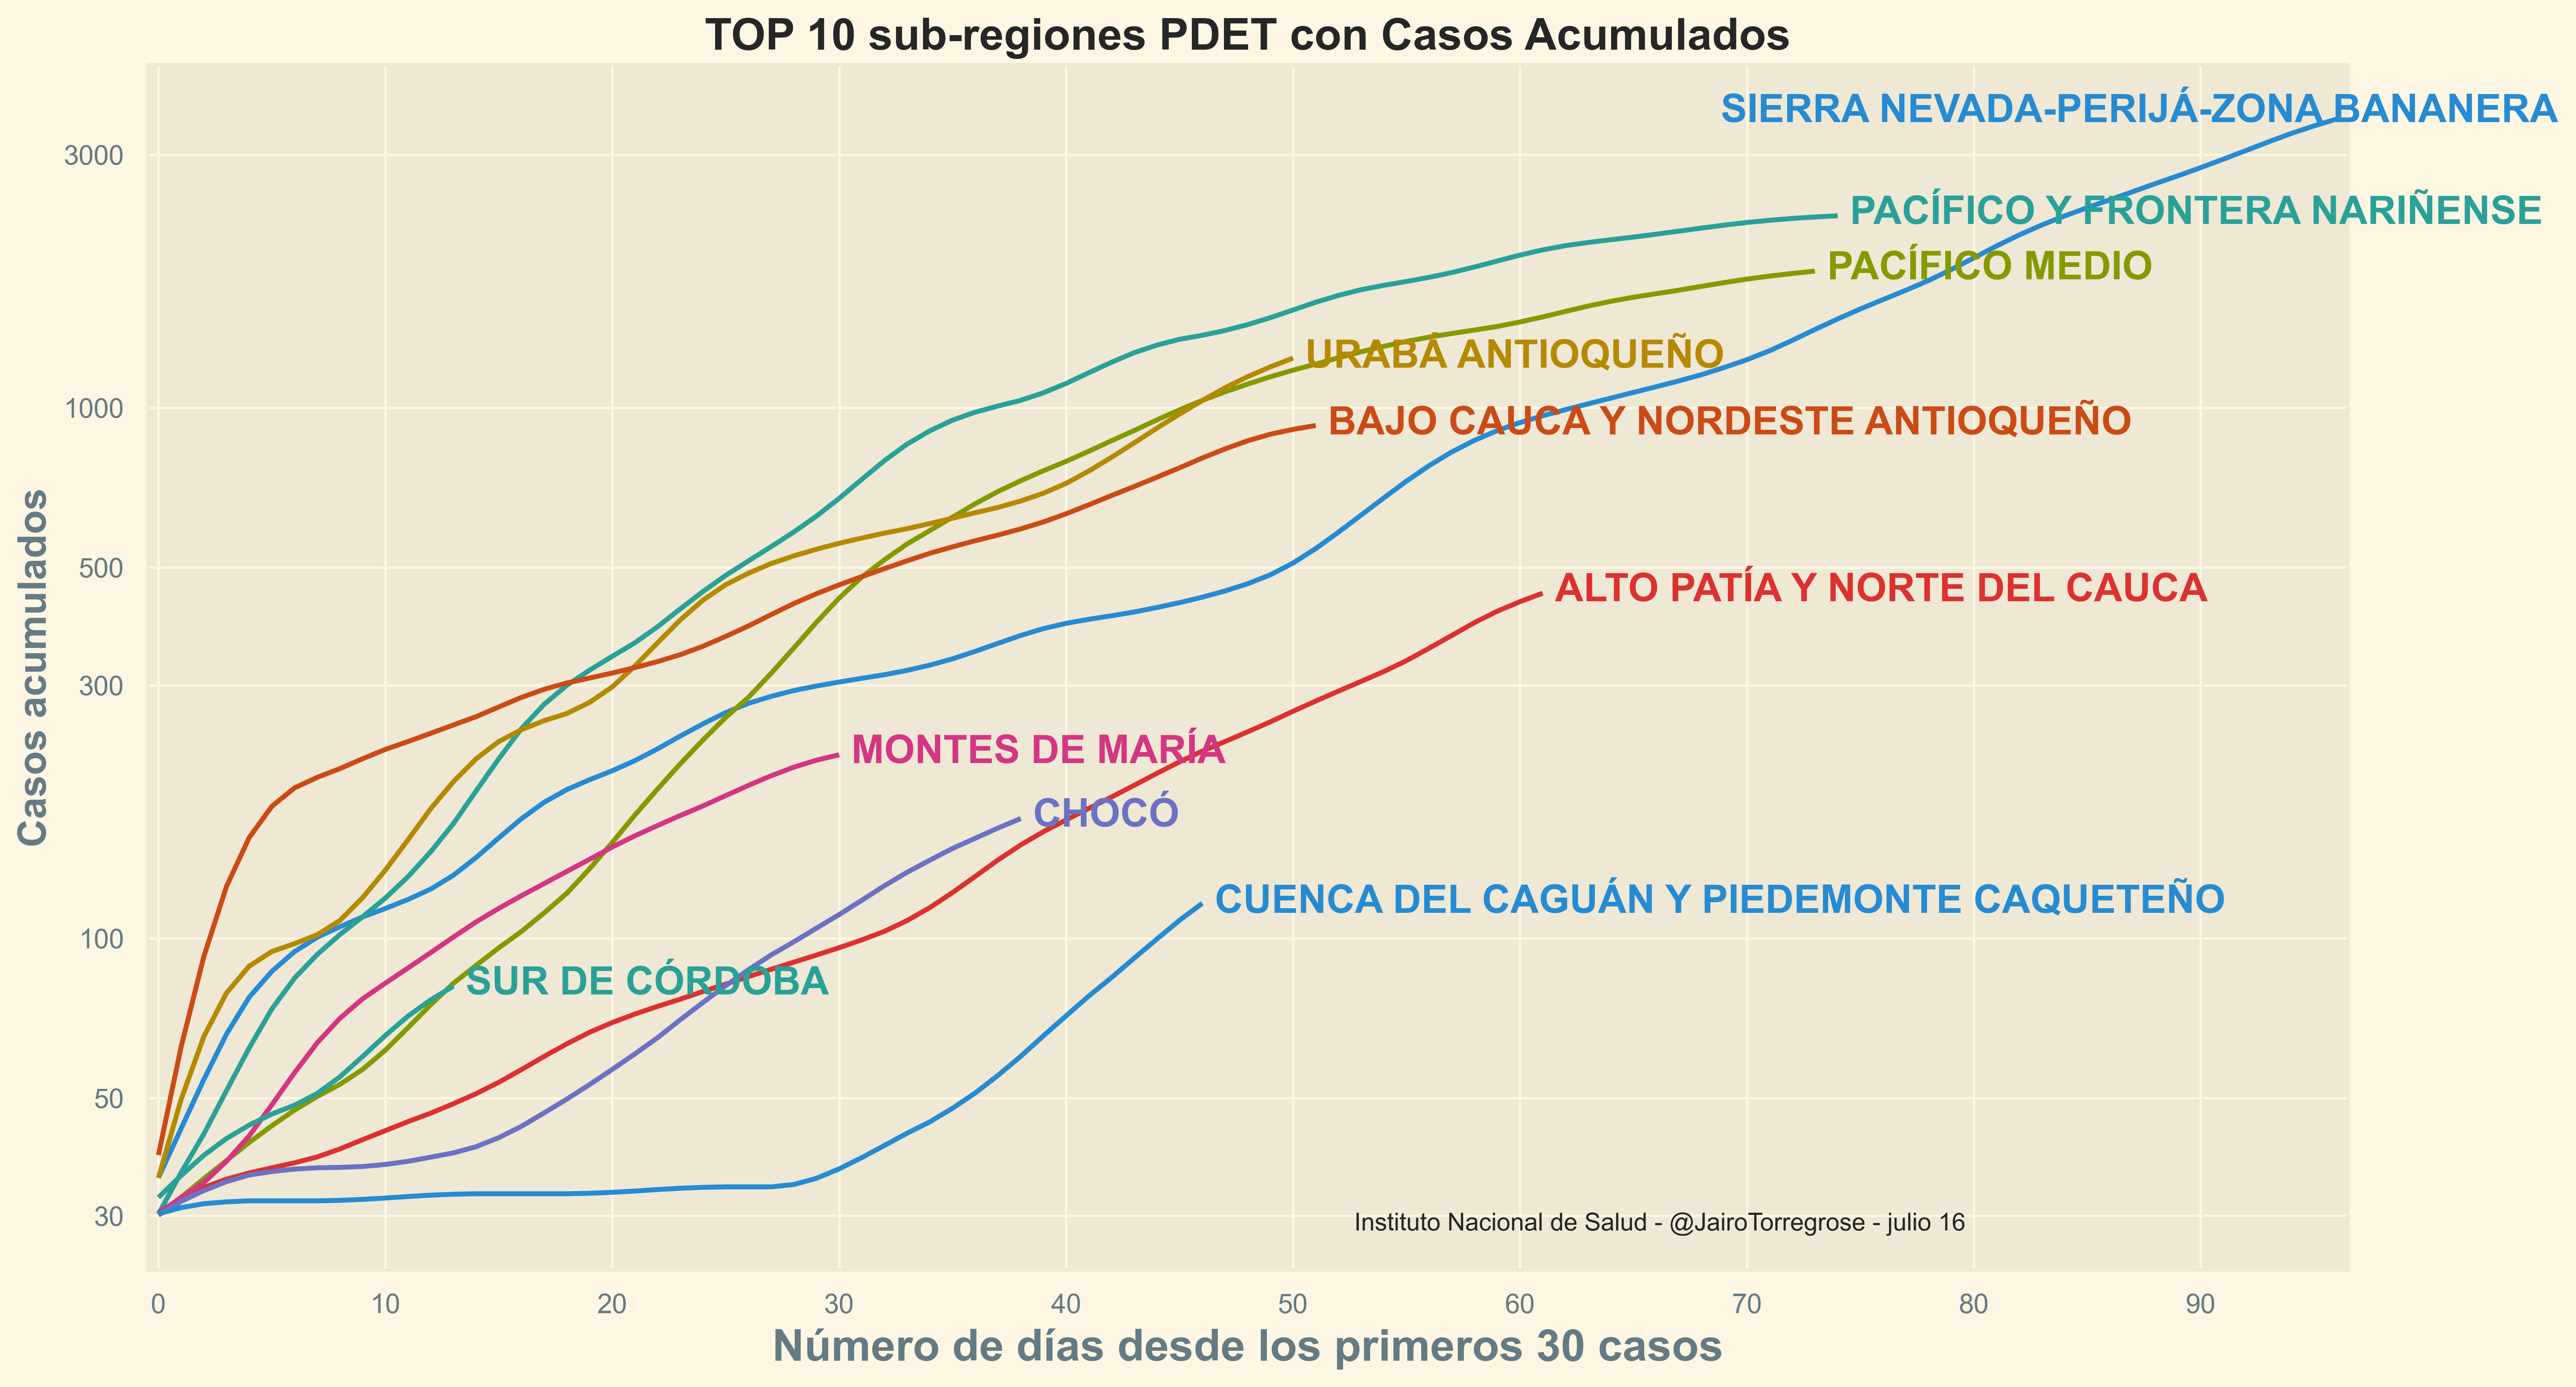

In [12]:
graficar(df_casos_acum_pdet, titulo_casos_acumulados_pdet,xlabel_casos_acumulados_pdet, ylabel_casos_acumulados_pdet,texto_col)

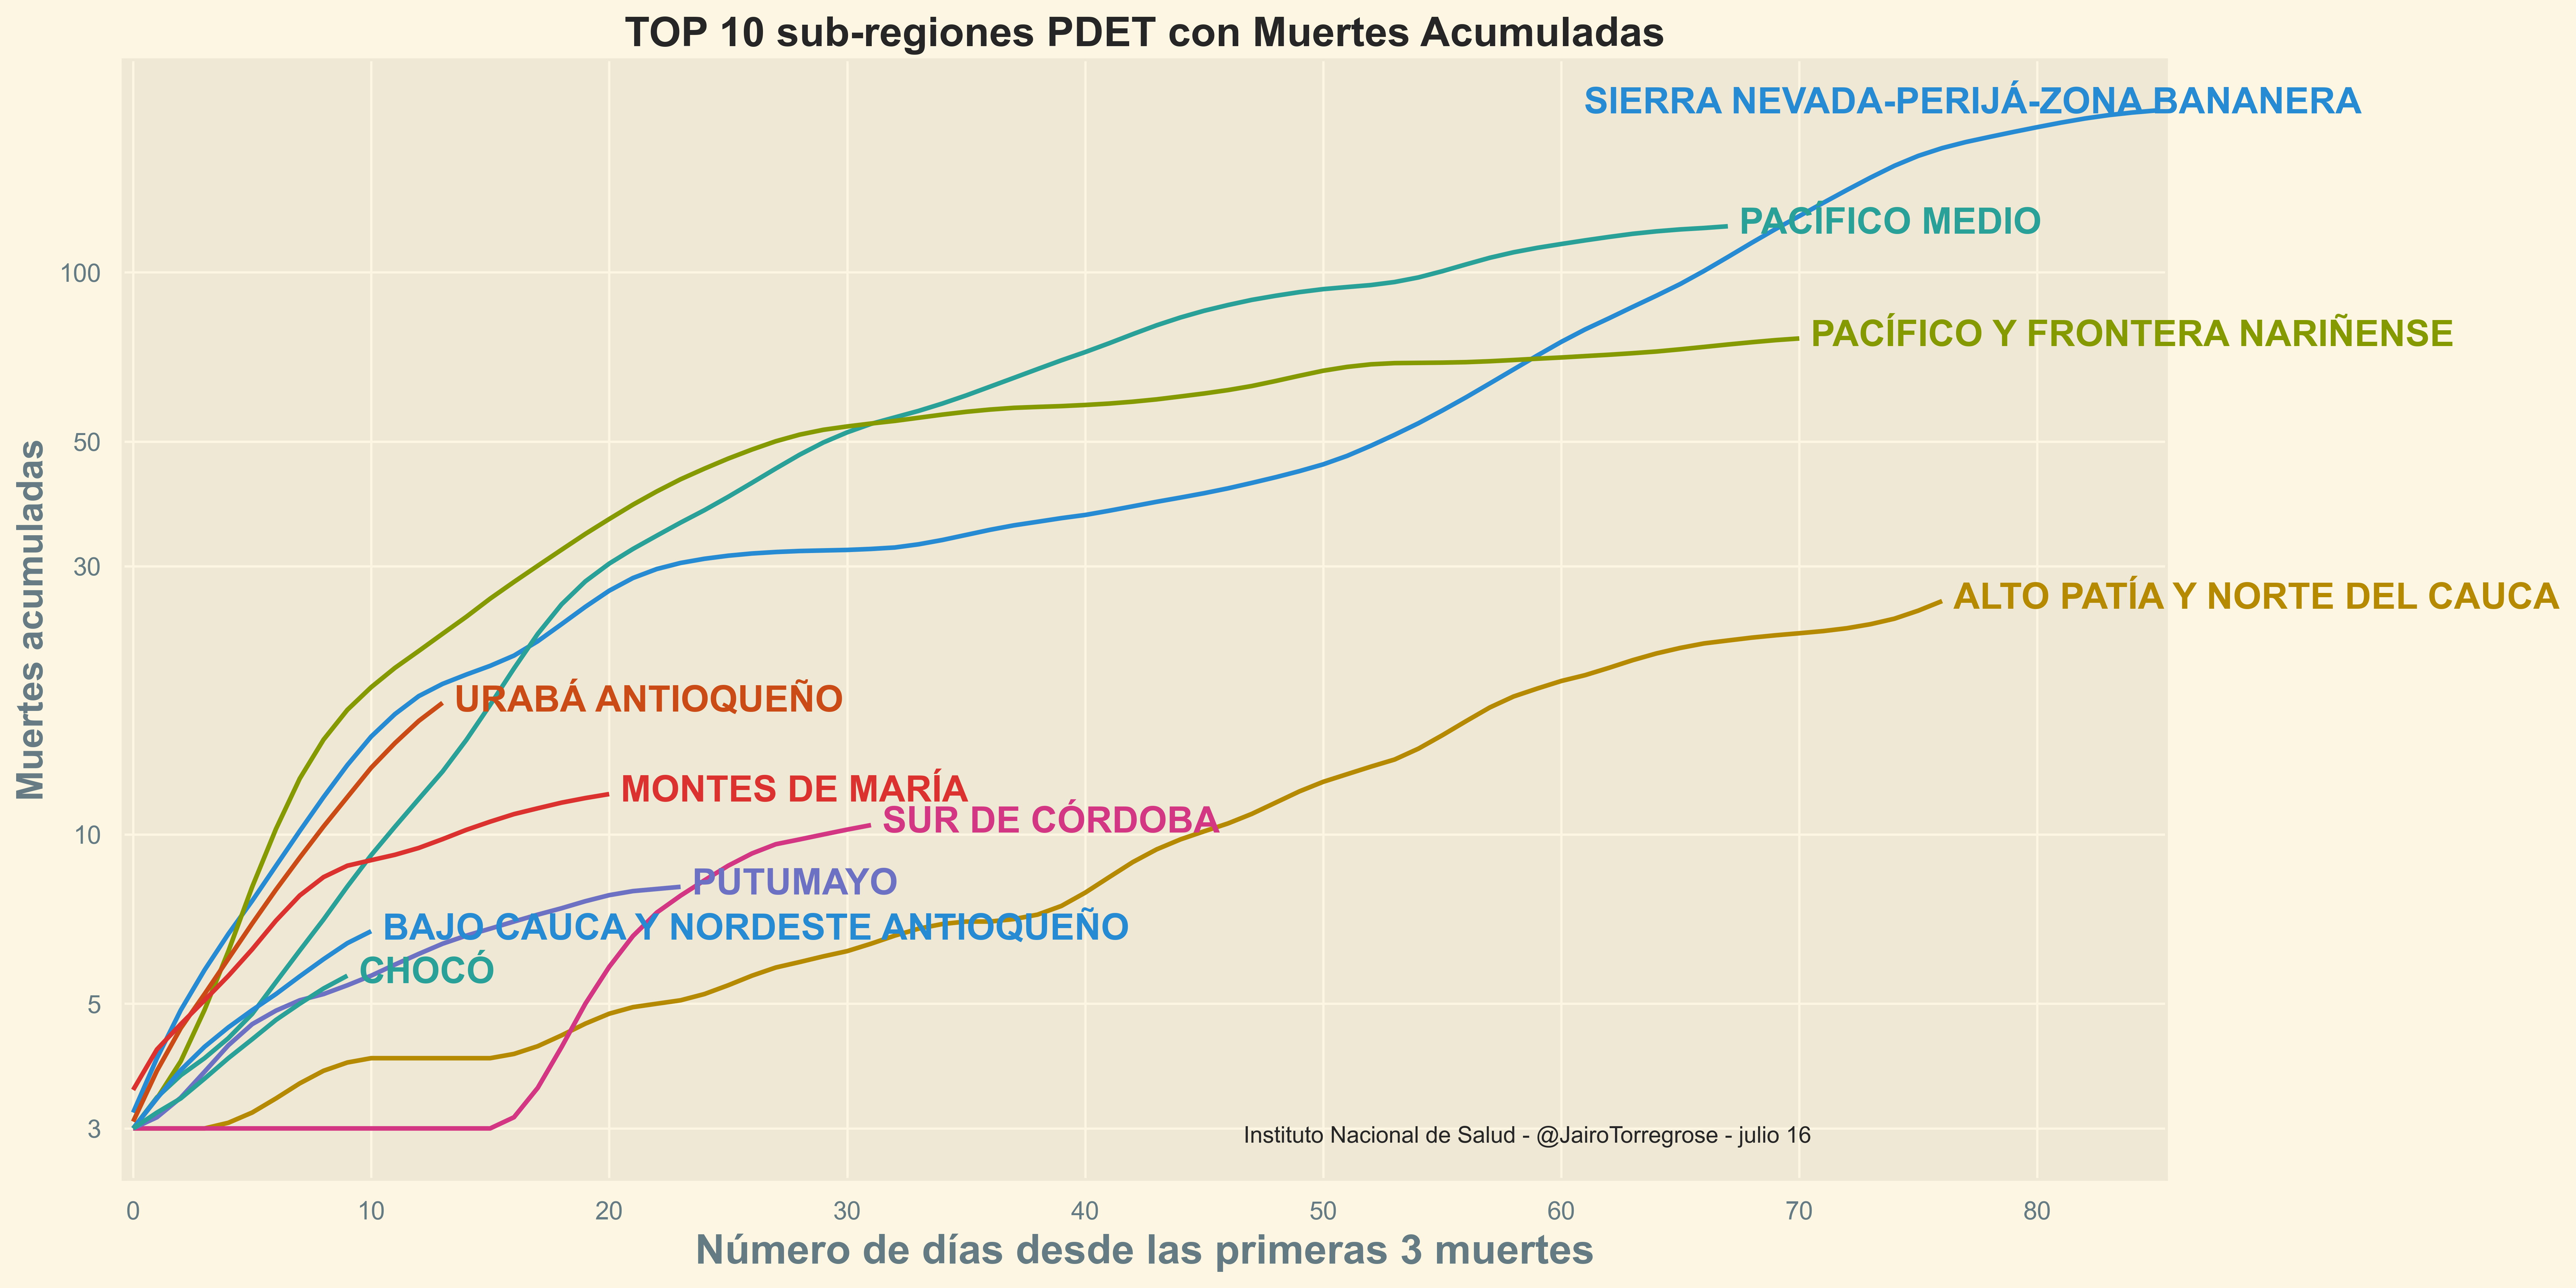

In [13]:
graficar(df_muertes_acum_pdet,titulo_muertes_acumuladas_pdet,xlabel_muertes_acumuladas_pdet,ylabel_muertes_acumuladas_pdet,texto_col)

In [14]:
#graficar(df_casos_diarios_pdet,titulo_casos_diarios_pdet,xlabel_casos_diarios_pdet,ylabel_casos_diarios_pdet,texto_col)